# Correlation with clinical outcome

One limitation of the previous approach is that it only considers mutations in 3 genes: FLT3, NPM1 and DNMT3A. However, patients with mutations in other genes, which may play an equally important role in AML prognosis, are not well-represented in the analysis. 
  
As one of the goals of model merging, we want to capture a more comprehensive AML gene regulation landscape, therefore, we next identified patients’ mutation profiles using all available genes covered by the model and tested the models’ prediction on their blast percentage.


In [2]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

# model1name = "Bonzanni2013"
# model2name = "Krumsiek2011"

# BeatAML
805 patients (942 specimens) in total. 
> For DNA sequencing, we used the 11.9 megabase custom capture library that was developed to provide coverage of all variants previously reported in AML (including all variants that were detected from exome sequencing in our prior study).

# Clinical Outcome
## Data
Mutation, clinical data and drug response data are downloaded from the [BeatAML2 website](https://biodev.github.io/BeatAML2/):
1. [WES/targeted Sequencing Mutation Calls](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt)
2. [Clinical Summary](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx)
3. [Inhibitor AUC values](https://github.com/biodev/beataml2.0_data/raw/main/beataml_probit_curve_fits_v4_dbgap.txt)
4. [Inhibitor Families](https://github.com/biodev/beataml2.0_data/raw/main/beataml_drug_families.xlsx)

## Methods
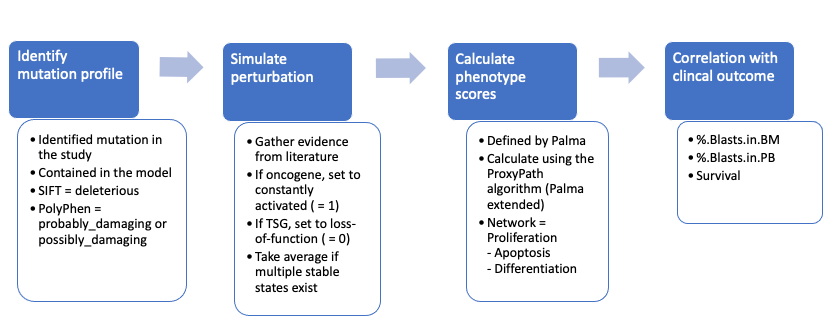

In [30]:
#!pip install adjustText

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations, chain  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
import xml.etree.ElementTree as ET # for parse the SBML file
import seaborn as sns # for plotting
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy import stats
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from adjustText import adjust_text

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [3]:
# Convert txt to SBML
from rpy2.robjects.packages import importr
boolnet = importr("BoolNet")

merged_and_name = "./Models/merged_and_" + model1name + "_" + model2name
merged_inhibitor_wins_name = "./Models/merged_inhibitor_wins_" + model1name + "_" + model2name
merged_or_name = "./Models/merged_or_" + model1name + "_" + model2name

for modelname in [merged_and_name, merged_inhibitor_wins_name, merged_or_name]:
    net = boolnet.loadNetwork(modelname + ".txt")
    boolnet.toSBML(net, modelname + ".sbml")
    print(modelname)
    print(boolnet.loadSBML(modelname + ".sbml"))
    print("_________________________________")

./Models/merged_and_Palma2021_Ikonomi2020
Boolean network with 50 genes

Involved genes:
EXTERNAL_QUIESCENCE EXTERNAL_CYCLING PIK3CA TSC1 MTOR FOXO3 ATM ROS1 MITOCHONDRIA AUTOPHAGY NRAS ETS1 MEFV CTNNB1 BMI1 MDM2 CDKN1C CDKN1A CDKN1B GFI1 RB1 E2F1 CCNE1 S_PHASE CDKN2D PRO_APOPTOTIC_PROTEINS ANTI_APOPTOTIC_PROTEINS CYCS SENESCENCE CDKN2A CCND1 AKT1 TP53 GSK3B MYC APOPTOSIS FLT3 NPM1 BCL2 CEBPA DIFFERENTIATION DNMT3A MAPK1 ETV6 FBXW7 HOXA9 MEIS1 PROLIFERATION SOX4 STAT5A

Transition functions:
EXTERNAL_QUIESCENCE = EXTERNAL_QUIESCENCE
EXTERNAL_CYCLING = EXTERNAL_CYCLING
PIK3CA = NRAS
TSC1 = !AKT1
MTOR = !TSC1
FOXO3 = (EXTERNAL_QUIESCENCE & !AKT1)
ATM = FOXO3
ROS1 = (MITOCHONDRIA | !ATM | !FOXO3 | !BMI1 | !TP53)
MITOCHONDRIA = MTOR
AUTOPHAGY = (FOXO3 & ROS1 & !MTOR)
NRAS = EXTERNAL_CYCLING
ETS1 = (NRAS & !MEFV)
MEFV = NRAS
CTNNB1 = !GSK3B
BMI1 = (MYC | (ATM & FOXO3))
MDM2 = ((TP53 | MEFV) & !CDKN2D & !ATM)
CDKN1C = (EXTERNAL_QUIESCENCE | FOXO3)
CDKN1A = ((TP53 | FOXO3 | EXTERNAL_QUIESCENC

In [4]:
# Read the data
mutations = pd.read_csv("../Data/BeatAML/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("../Data/BeatAML/beataml_wv1to4_clinical.xlsx")
classification = pd.read_csv("../Standardizing and annotating models/class_"+ model1name + "_" + model2name +".csv")

model1 = biolqm.load("../Models/" + model1name + ".sbml")
model2 = biolqm.load("../Models/" + model2name + ".sbml")
merged_and = biolqm.load("../Models/merged_and_" + model1name + "_" + model2name + ".sbml")
merged_inhibitor_wins = biolqm.load("../Models/merged_inhibitor_wins_" + model1name + "_" + model2name + ".sbml")
merged_or = biolqm.load("../Models/merged_or_" + model1name + "_" + model2name + ".sbml")

In [5]:
# Get genes in each model
def getnodes(model_name):
    # Load and parse the SBML file
    tree = ET.parse("../Models/" + model_name + ".sbml")
    root = tree.getroot()
    
    # Define the namespace for SBML Level 3 Version 1 Core and Qual
    ns = {
        'sbml': 'http://www.sbml.org/sbml/level3/version1/core',
        'qual': 'http://www.sbml.org/sbml/level3/version1/qual/version1'
    }
    
    # Find all qualitativeSpecies in the model
    qual_species_list = root.findall('.//qual:qualitativeSpecies', ns)
    
    # Extract the IDs of the qualitativeSpecies
    qual_species_ids = []
    for species in qual_species_list:
        species_id = species.attrib.get('{http://www.sbml.org/sbml/level3/version1/qual/version1}id')
        if species_id:
            qual_species_ids.append(species_id)

    print(qual_species_ids)
    return qual_species_ids
    
gene_model1 = getnodes(model1name)
gene_model2 = getnodes(model2name)
gene_merged = list(set(gene_model1 + gene_model2))

['AKT1', 'CDKN2A', 'BCL2', 'CCND1', 'CEBPA', 'DNMT3A', 'MAPK1', 'ETV6', 'FBXW7', 'FLT3', 'GSK3B', 'HOXA9', 'MEIS1', 'MYC', 'NPM1', 'SOX4', 'STAT5A', 'TP53']
['External_quiescence', 'External_cycling', 'PIK3CA', 'TSC1', 'MTOR', 'FOXO3', 'ATM', 'ROS1', 'Mitochondria', 'Autophagy', 'ERAS', 'ETS1', 'MEFV', 'GSK3B', 'CTNNB1', 'MYC', 'BMI1', 'MDM2', 'TP53', 'CDKN1C', 'CDKN1A', 'CDKN1B', 'GFI1', 'RB1', 'E2F1', 'CCND1', 'CCNE1', 'S_phase', 'AKT1', 'CDKN2D', 'CDKN2A', 'Pro_apoptotic_proteins', 'Anti_apoptotic_proteins', 'CYCS', 'Apoptosis', 'Senescence']


In [6]:
# Merge the df based on sample id
df = pd.merge(
    left=mutations,
    right=clinical,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample'
)
df['survivalYears'] = df['ageAtDiagnosis'] + df['overallSurvival']/365

# Add FLT3-ITD
flt3_positive_df = df[df['FLT3-ITD'] == 'positive'].copy()
flt3_positive_df['symbol'] = 'FLT3'

# Add NPM1
#npm1_positive_df = df[df['NPM1'] == 'positive'].copy()
#npm1_positive_df['symbol'] = 'NPM1'

# Add TP53
#tp53_positive_df = df[pd.notna(df['TP53'])].copy()
#tp53_positive_df['symbol'] = 'TP53'

# Add RUNX1
#runx1_positive_df = df[pd.notna(df['RUNX1'])].copy()
#runx1_positive_df['symbol'] = 'RUNX1'

#clinical_df = pd.concat([df, flt3_positive_df, npm1_positive_df, tp53_positive_df, runx1_positive_df], ignore_index=True)
clinical_df = pd.concat([df, flt3_positive_df], ignore_index=True)

# Filter the 'mutations' DataFrame
mutations_df = clinical_df[
    (clinical_df['symbol'].isin(gene_model1)) &
    (
        # Apply 'sift' and 'polyphen' filters 
        ((clinical_df['sift'].str.startswith('deleterious')) &
         (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging')))
    ))
]
mutations_df_2 = clinical_df[
    (clinical_df['symbol'].isin(gene_model2)) &
    (
        # Apply 'sift' and 'polyphen' filters 
        ((clinical_df['sift'].str.startswith('deleterious')) &
         (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging')))
    ))
]
# mutations_df = clinical_df[clinical_df['symbol'].isin(gene_model1)]
# mutations_df_2 = clinical_df[clinical_df['symbol'].isin(gene_model2)]

patient_to_mutations = mutations_df.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()
patient_to_mutations_2 = mutations_df_2.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()

# Generate unique mutation profiles and their perturbation strings
classification_dict = classification.set_index('symbol')['class'].to_dict()

def generate_perturbation_string(mutations):
    perturbations = []
    for mutation in mutations:
        class_type = classification_dict.get(mutation)
        if class_type == 'oncogene':
            perturbations.append(f"{mutation}%1")
        elif class_type == 'TSG':
            perturbations.append(f"{mutation}%0")
    return " ".join(perturbations)

# def generate_perturbation_string(mutations):
#     perturbations = []
#     for mutation in mutations:
#         perturbations.append(f"{mutation}%0")
#     return " ".join(perturbations)
    
patient_to_mutations['perturbation_string'] = patient_to_mutations['symbol'].apply(generate_perturbation_string)
patient_to_mutations_2['perturbation_string'] = patient_to_mutations_2['symbol'].apply(generate_perturbation_string)

unique_perturbations = patient_to_mutations['perturbation_string'].unique()
unique_perturbations_2 = patient_to_mutations_2['perturbation_string'].unique()

perturbation_to_scores = {}

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(model1, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

# Map the simulation results back to each patient
patient_to_mutations['symbol'] = patient_to_mutations['symbol'].str.join(', ')
patient_to_mutations['palma_network_score'] = patient_to_mutations['perturbation_string'].map(perturbation_to_scores)
print("# of patients per mutation profile:")
patient_to_mutations['symbol'].value_counts()

# of patients per mutation profile:


symbol
FLT3                  141
DNMT3A                 59
FLT3, DNMT3A           46
TP53                   41
DNMT3A, FLT3           10
MYC                     4
DNMT3A, TP53            4
FLT3, MYC, DNMT3A       2
CEBPA                   2
FLT3, ETV6              1
NPM1, FLT3, DNMT3A      1
CEBPA, DNMT3A           1
NPM1                    1
FLT3, TP53              1
ETV6                    1
Name: count, dtype: int64

In [7]:
mutations_df = mutations_df.copy()

# mapping dbgap_subject_id to symbol (mutation profile)
subject_to_symbol = patient_to_mutations[['dbgap_subject_id', 'symbol']].set_index('dbgap_subject_id').to_dict()['symbol']
mutations_df['mutation_profile_palma'] = mutations_df['dbgap_subject_id'].map(subject_to_symbol)

# mapping dbgap_subject_id to pertubation string
subject_to_pertstr = patient_to_mutations[['dbgap_subject_id', 'perturbation_string']].set_index('dbgap_subject_id').to_dict()['perturbation_string']
mutations_df['perturbation_string_palma'] = mutations_df['dbgap_subject_id'].map(subject_to_pertstr)

# mapping dbgap_subject_id to network_score
subject_to_score = patient_to_mutations[['dbgap_subject_id', 'palma_network_score']].set_index('dbgap_subject_id').to_dict()['palma_network_score']
mutations_df['palma_network_score'] = mutations_df['dbgap_subject_id'].map(subject_to_score)

# Update 'network_score' for wildtype
fps = biolqm.fixpoints(model1)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']

# Identify patients in clinical_df but not in mutations_df
all_patients = set(clinical_df['dbgap_subject_id'])
patients_with_mutations = set(mutations_df['dbgap_subject_id'])
patients_without_mutations = all_patients - patients_with_mutations

# Create a new DataFrame for these patients
wt_patients_df = clinical_df[clinical_df['dbgap_subject_id'].isin(patients_without_mutations)].copy()
wt_patients_df['mutation_profile_palma'] = 'wt'
wt_patients_df['palma_network_score'] = network_score_wt

# Concatenate the new DataFrame with mutations_df
mutations_df = pd.concat([mutations_df, wt_patients_df], ignore_index=True)

# The merged models

In [11]:
# Filter the 'mutations' DataFrame
merged_df = clinical_df[
    (clinical_df['symbol'].isin(gene_merged)) &
    (
        # Apply 'sift' and 'polyphen' filters
        ((clinical_df['sift'].str.startswith('deleterious')) &
         (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging'))))
    )
]

# merged_df = clinical_df[clinical_df['symbol'].isin(gene_merged)]
patient_to_mutations = merged_df.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()

# Generate unique mutation profiles and their perturbation strings
classification_dict = classification.set_index('symbol')['class'].to_dict()

def generate_perturbation_string(mutations):
    perturbations = []
    for mutation in mutations:
        class_type = classification_dict.get(mutation)
        if class_type == 'oncogene':
            perturbations.append(f"{mutation}%1")
        elif class_type == 'TSG':
            perturbations.append(f"{mutation}%0")
    return " ".join(perturbations)

# def generate_perturbation_string(mutations):
#     perturbations = []
#     for mutation in mutations:
#         perturbations.append(f"{mutation}%0")
#     return " ".join(perturbations)
    
patient_to_mutations['perturbation_string'] = patient_to_mutations['symbol'].apply(generate_perturbation_string)
unique_perturbations = patient_to_mutations['perturbation_string'].unique()

# Map the simulation results back to each patient
patient_to_mutations['symbol'] = patient_to_mutations['symbol'].str.join(', ')
print("# of patients per mutation profile:")
patient_to_mutations['symbol'].value_counts()

# of patients per mutation profile:


symbol
FLT3                  141
DNMT3A                 59
FLT3, DNMT3A           46
TP53                   41
DNMT3A, FLT3           10
MYC                     4
DNMT3A, TP53            4
CEBPA                   2
ATM                     2
FLT3, MYC, DNMT3A       2
FLT3, TP53              1
NPM1                    1
MTOR                    1
PIK3CA                  1
CEBPA, DNMT3A           1
NPM1, FLT3, DNMT3A      1
FLT3, ETV6              1
ETV6                    1
Name: count, dtype: int64

In [12]:
#___________________ merged_and _________________
merged_df = merged_df.copy()
perturbation_to_scores = {}

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_and, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']
        
# Map the simulation results back to each patient
patient_to_mutations['network_score'] = patient_to_mutations['perturbation_string'].map(perturbation_to_scores)

# mapping dbgap_subject_id to pertubation string
subject_to_pertstr = patient_to_mutations[['dbgap_subject_id', 'perturbation_string']].set_index('dbgap_subject_id').to_dict()['perturbation_string']
merged_df['perturbation_string_merged'] = mutations_df['dbgap_subject_id'].map(subject_to_pertstr)

# mapping dbgap_subject_id to symbol (mutation profile)
subject_to_symbol = patient_to_mutations[['dbgap_subject_id', 'symbol']].set_index('dbgap_subject_id').to_dict()['symbol']
merged_df['mutation_profile_merged'] = merged_df['dbgap_subject_id'].map(subject_to_symbol)

# mapping dbgap_subject_id to network_score
subject_to_score = patient_to_mutations[['dbgap_subject_id', 'network_score']].set_index('dbgap_subject_id').to_dict()['network_score']
merged_df['merged_and_network_score'] = merged_df['dbgap_subject_id'].map(subject_to_score)

# Update 'network_score' for wildtype
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_and = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']

# Identify patients in clinical_df but not in mutations_df
all_patients = set(clinical_df['dbgap_subject_id'])
patients_with_mutations = set(merged_df['dbgap_subject_id'])
patients_without_mutations = all_patients - patients_with_mutations

# Create a new DataFrame for these patients
wt_patients_df = clinical_df[clinical_df['dbgap_subject_id'].isin(patients_without_mutations)].copy()
wt_patients_df['mutation_profile_merged'] = 'wt'
wt_patients_df['merged_and_network_score'] = network_score_and

# Concatenate the new DataFrame with merged_df
merged_df = pd.concat([merged_df, wt_patients_df], ignore_index=True)

#___________________ merged_inhibitor_wins_________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_inhibitor_wins, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']
        
# Map the simulation results back to each patient
patient_to_mutations['network_score'] = patient_to_mutations['perturbation_string'].map(perturbation_to_scores)

# mapping dbgap_subject_id to network_score
subject_to_score = patient_to_mutations[['dbgap_subject_id', 'network_score']].set_index('dbgap_subject_id').to_dict()['network_score']
merged_df['merged_inhibitor_wins_network_score'] = merged_df['dbgap_subject_id'].map(subject_to_score)

# Update 'network_score' 
fps = biolqm.fixpoints(merged_inhibitor_wins)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
merged_df.loc[merged_df['mutation_profile_merged'] == 'wt', 'merged_inhibitor_wins_network_score'] = network_score_wt

#___________________ merged_or_________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_or, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']
        
# Map the simulation results back to each patient
patient_to_mutations['network_score'] = patient_to_mutations['perturbation_string'].map(perturbation_to_scores)

# mapping dbgap_subject_id to network_score
subject_to_score = patient_to_mutations[['dbgap_subject_id', 'network_score']].set_index('dbgap_subject_id').to_dict()['network_score']
merged_df['merged_or_network_score'] = merged_df['dbgap_subject_id'].map(subject_to_score)

# Update 'network_score' 
fps = biolqm.fixpoints(merged_or)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
merged_df.loc[merged_df['mutation_profile_merged'] == 'wt', 'merged_or_network_score'] = network_score_wt

In [13]:
# merge the Palma model scores and merged model scores
palmascore = mutations_df[['dbgap_subject_id','mutation_profile_palma', 'perturbation_string_palma','palma_network_score']]
palmascore = palmascore.groupby('dbgap_subject_id').agg({
    'palma_network_score': 'mean',
    'mutation_profile_palma': 'first', 
    'perturbation_string_palma': 'first'
}).reset_index()
mutations_df = merged_df.merge(palmascore, on='dbgap_subject_id', how='left')

In [8]:
def correlation_plot(pheno, clinical_variable):
    if pheno.startswith('palma'):
        mutation_profile = 'mutation_profile_palma'
    else: mutation_profile = 'mutation_profile_merged'
    
    df = mutations_df
    # Convert clinical_variable to numeric, coercing errors to NaN
    df[clinical_variable] = pd.to_numeric(df[clinical_variable], errors='coerce')
    # Aggregate to ensure one row per patient
    aggregated_df = df.groupby('dbgap_subject_id').agg({
        clinical_variable: 'mean', 
        pheno: 'first',
        mutation_profile: 'first'
    }).reset_index()
    
    # Drop rows where either clinical_variable or pheno is NaN
    aggregated_df = aggregated_df.dropna(subset=[clinical_variable, pheno])
    
    if len(aggregated_df) > 1:  # Ensure there are at least 2 data points
        pc, p_value = pearsonr(aggregated_df[clinical_variable], aggregated_df[pheno])
    
        # Plotting
        plt.figure(figsize=(6, 6))
        
        # Get unique mutation profiles and assign colors
        unique_profiles = aggregated_df[mutation_profile].unique()
        palette = sns.color_palette("Set2", len(unique_profiles))
        color_dict = dict(zip(unique_profiles, palette))
        
        # Plot the regression line using seaborn (without scatter points)
        plot = sns.regplot(x=pheno, y=clinical_variable, data=aggregated_df, ci=None, scatter=False, color='gray')

        # Plot points with colors based on 'mutation_profile'
        for _, row in aggregated_df.iterrows():
            alpha_value = 0.1 if row[mutation_profile] == 'wildtype' else 1
            color_value = "Grey" if row[mutation_profile] == 'wildtype' else color_dict[row[mutation_profile]]
            plt.scatter(row[pheno], row[clinical_variable], color=color_value, 
                        s=50, alpha=alpha_value, label=row[mutation_profile])
        
        annotated_profiles = set()  # Keep track of annotated mutation profiles
        for _, row in aggregated_df.iterrows():
            profile = row[mutation_profile]
            # Annotate each unique mutation profile only once
            if profile not in annotated_profiles:
                plt.annotate(profile, (row[pheno], row[clinical_variable]), fontsize=9)
                annotated_profiles.add(profile)
                
        plt.title('Correlation analysis of ' + clinical_variable + ' vs ' + pheno)
        plt.xlabel(pheno)
        plt.ylabel(clinical_variable)
        # Annotating the plot with Pearson Correlation and p-value
        plt.text(0.5, 0.1, f'Pearson Correlation: {pc:.2f}\nP-value: {p_value:.2g}', transform=plot.transAxes, verticalalignment='top')
    
        plt.show()
    else:
        print("Not enough data points for correlation analysis.")

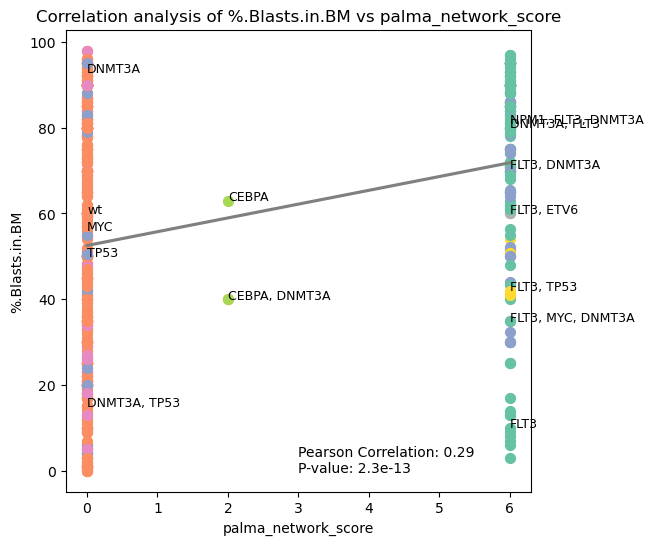

In [9]:
correlation_plot('palma_network_score', '%.Blasts.in.BM')

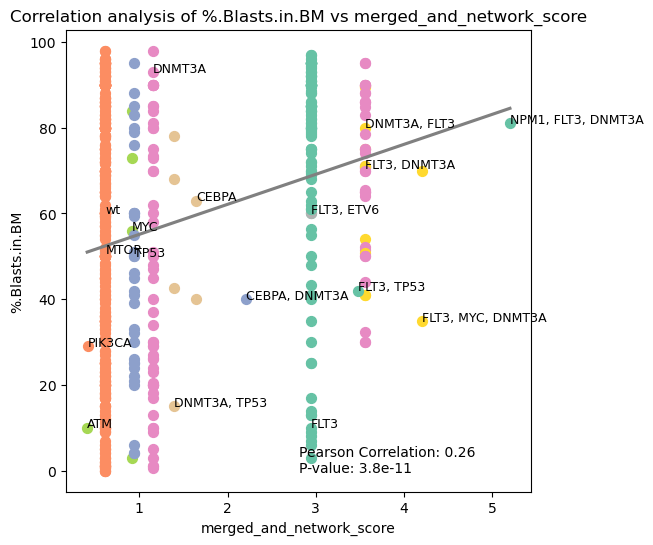

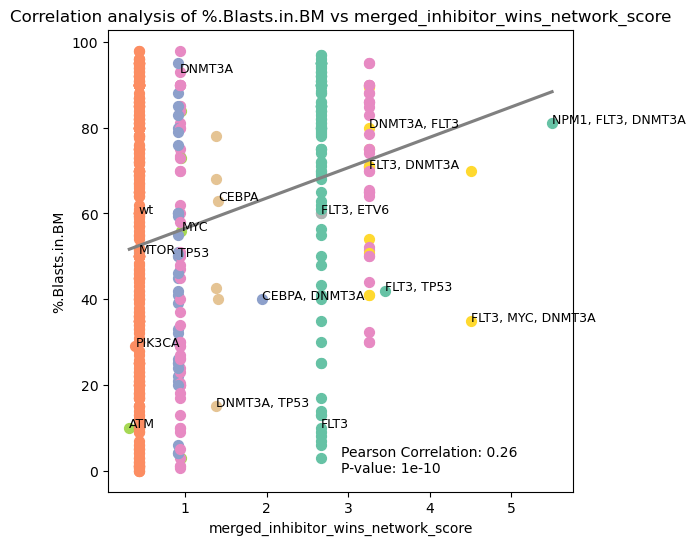

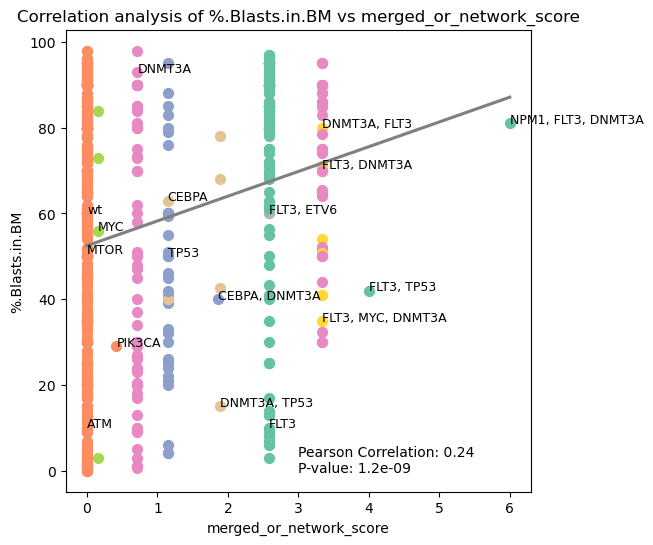

In [14]:
correlation_plot('merged_and_network_score', '%.Blasts.in.BM')
correlation_plot('merged_inhibitor_wins_network_score', '%.Blasts.in.BM')
correlation_plot('merged_or_network_score', '%.Blasts.in.BM')

In [14]:
def correlation_pc(clinical_variable):
    mutation_profile = 'mutation_profile_palma'
        
    df = mutations_df
    pc_results = pd.DataFrame()
    # loop through the models
    models = ['palma', 'merged_and', 'merged_inhibitor_wins', 'merged_or']
    for model in models:
        pheno = model + "_network_score"
        
        # Aggregate to ensure one row per patient
        aggregated_df = df.groupby('dbgap_subject_id').agg({
            clinical_variable: 'mean', 
            pheno: 'first',
            mutation_profile: 'first'
        }).reset_index()
        
        # Drop rows where either clinical_variable or pheno is NaN
        aggregated_df = aggregated_df.dropna(subset=[clinical_variable, pheno])
        
        # Extract hazard ratio and phenotype values
        x = aggregated_df[pheno]
        y = aggregated_df[clinical_variable]
        
        # Calculate Pearson Correlation and p-value
        pc_results.loc[model, 'pc'], pc_results.loc[model, 'p_value'] = pearsonr(x, y)
    print('Person Correlation of '+ clinical_variable + ' vs Phenotype score')
    return pc_results
correlation_pc('%.Blasts.in.BM')

Person Correlation of %.Blasts.in.BM vs Phenotype score


,pc,p_value
palma,0.437548,1.387387e-13
merged_and,0.419119,1.303948e-12
merged_inhibitor_wins,0.410656,4.022611e-12
merged_or,0.400012,1.587230e-11


## Aggregate over mutation profile

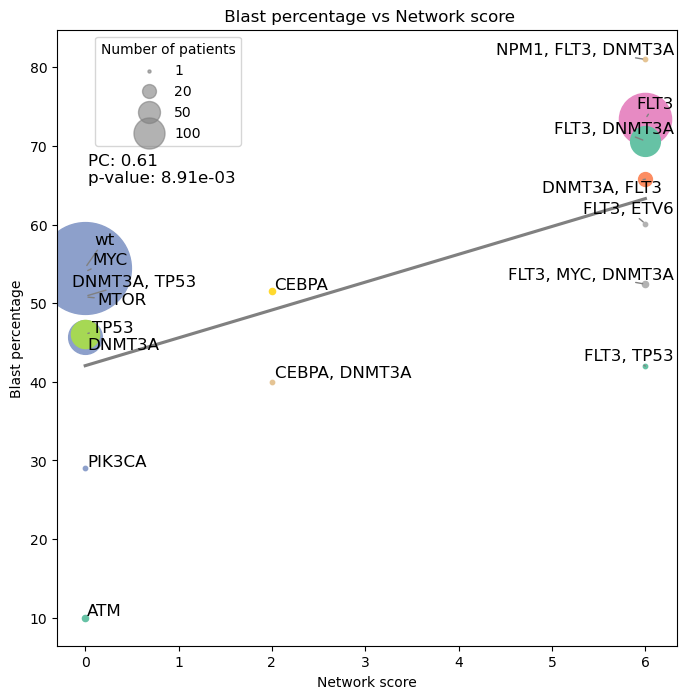

In [15]:
# Define a persistent color palette for known mutation profiles

all_possible_profiles = mutations_df['mutation_profile_merged'].unique()
palette = sns.color_palette("Set2", len(all_possible_profiles))
persistent_color_dict = dict(zip(all_possible_profiles, palette))

def correlation_plot_avg(pheno, clinical_variable):
    mutation_profile = 'mutation_profile_merged'
    
    df = mutations_df
    # Convert clinical_variable to numeric, coercing errors to NaN
    df[clinical_variable] = pd.to_numeric(df[clinical_variable], errors='coerce')
    # Aggregate to ensure one row per patient
    patient_df = df.groupby('dbgap_subject_id').agg({
        clinical_variable: 'mean', 
        pheno: 'first',
        mutation_profile: 'first'
    }).reset_index()

    # Aggregate to take average over clinical outcomes
    aggregated_df = patient_df.groupby(mutation_profile).agg({
        clinical_variable: 'mean', 
        pheno: 'first'
    }).reset_index()
    
    # Drop rows where either clinical_variable or pheno is NaN
    aggregated_df = aggregated_df.dropna(subset=[clinical_variable, pheno])
    
    # Count the number of occurrences of each mutation profile
    profile_counts = patient_df[mutation_profile].value_counts().to_dict()
    aggregated_df['profile_count'] = aggregated_df[mutation_profile].map(profile_counts)
    
    if len(aggregated_df) > 1:  # Ensure there are at least 2 data points
        pc, p_value = pearsonr(aggregated_df[clinical_variable], aggregated_df[pheno])
    
        # Plotting
        plt.figure(figsize=(8, 8))

        # Plot the regression line using seaborn (without scatter points)
        plot = sns.regplot(x=pheno, y=clinical_variable, data=aggregated_df, ci=None, scatter=False, color='gray')

        # Plot points with colors based on 'mutation_profile' and sizes based on profile counts
        sizes = []
        texts = []
        for _, row in aggregated_df.iterrows():
            alpha_value = 0.1 if row[mutation_profile] == 'wildtype' else 1
            color_value = persistent_color_dict.get(row[mutation_profile], "Grey")  # Default to grey if profile is not in persistent_color_dict
            size_value = row['profile_count'] * 10  # Adjust size multiplier as needed
            sizes.append(size_value)
            plt.scatter(row[pheno], row[clinical_variable], color=color_value, 
                        s=size_value, alpha=alpha_value, label=row[mutation_profile])
        
            # Annotate each unique mutation profile only once
            if row[mutation_profile] not in texts:
                texts.append(plt.text(row[pheno], row[clinical_variable], row[mutation_profile], fontsize=12))

        # Adjust text positions to avoid overlap
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))
        
        # Create custom legend for number of profiles using circles
        handles = []
        size_legend = [5, 100, 250, 500]  # Example sizes for legend
        for size in size_legend:
            handles.append(plt.scatter([], [], s=size, color='grey', alpha=0.6, label=f'{size//5}'))
        
        # Add legend for mutation profiles colors
        current_profiles = aggregated_df[mutation_profile].unique()
        color_handles = [mpatches.Patch(color=persistent_color_dict[profile], label=profile) for profile in current_profiles]

        
        plt.title(' Blast percentage vs Network score')
        plt.xlabel('Network score')
        plt.ylabel('Blast percentage')
        # Annotating the plot with Pearson Correlation and p-value
        if pheno == 'palma_network_score':
            plt.legend(handles=handles, title='Number of patients', bbox_to_anchor=(0.05, 1), loc='upper left', fontsize='medium')
            plt.text(0.05, 0.8, f'PC: {pc:.2f}\np-value: {p_value:.2e}', transform=plot.transAxes, verticalalignment='top', fontsize=12)
        else:
            plt.legend(handles=handles, title='Number of patients', bbox_to_anchor=(0.7, 0.3), loc='upper left', fontsize='medium')
            plt.text(0.7, 0.08, f'PC: {pc:.2f}\np-value: {p_value:.2e}', transform=plot.transAxes, verticalalignment='top', fontsize=12)
        plt.show()
    else:
        print("Not enough data points for correlation analysis.")

correlation_plot_avg( 'palma_network_score', '%.Blasts.in.BM')

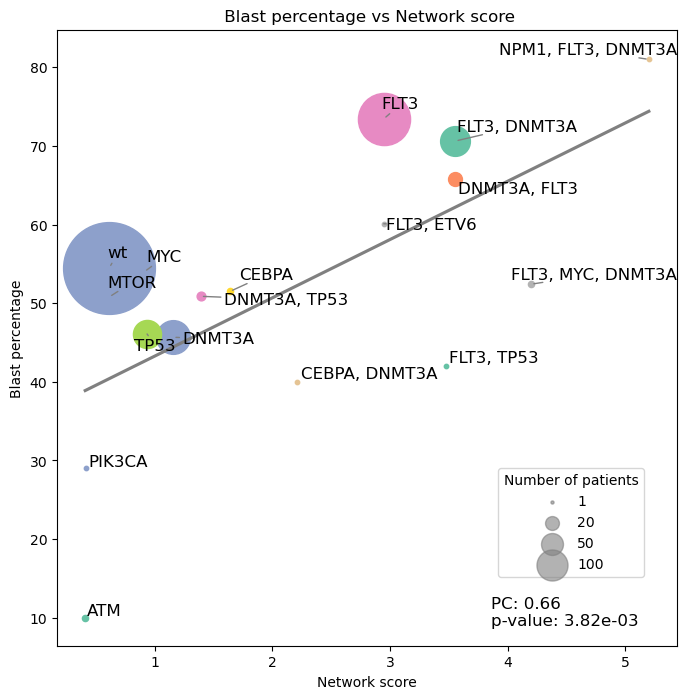

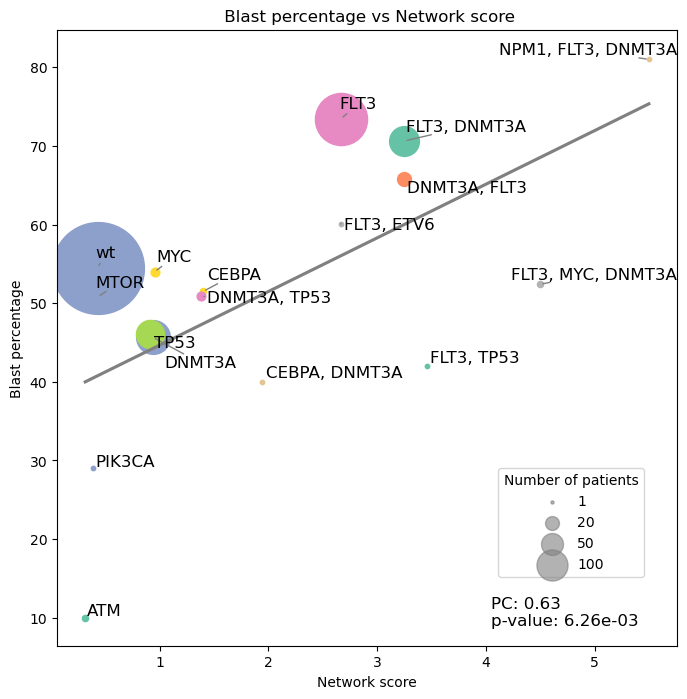

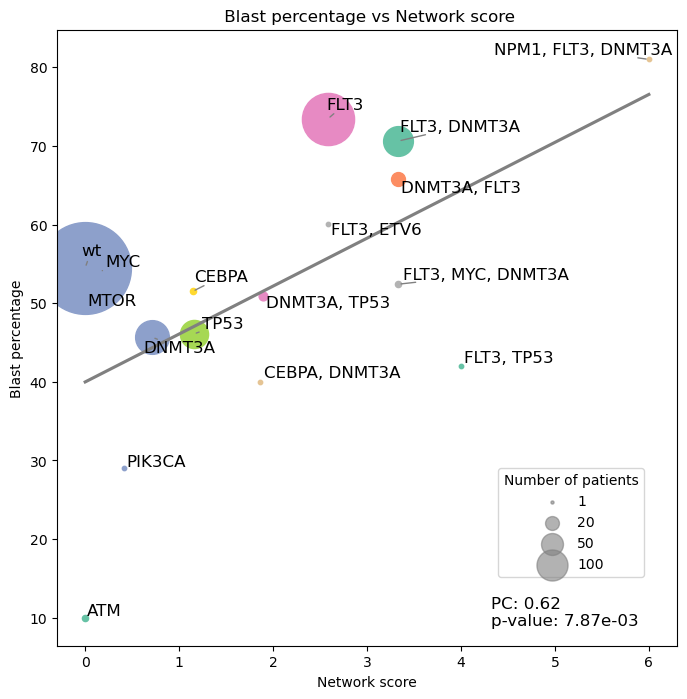

In [16]:
correlation_plot_avg( 'merged_and_network_score', '%.Blasts.in.BM')
correlation_plot_avg('merged_inhibitor_wins_network_score', '%.Blasts.in.BM')
correlation_plot_avg( 'merged_or_network_score', '%.Blasts.in.BM')

In [17]:
def correlation_pc_avg(clinical_variable, score='palma'):

    df = mutations_df
    pc_results = pd.DataFrame()
    # loop through the models
    models = ['palma', 'merged_and', 'merged_inhibitor_wins', 'merged_or']
    for model in models:

        if model.startswith('palma'):
            mutation_profile = 'mutation_profile_palma'
        else: mutation_profile = 'mutation_profile_merged'
        
        if score == 'proxypath':
            pheno = model + "_network_score_proxypath"
        else: pheno = model + "_network_score"
        
        # Aggregate to ensure one row per patient
        patient_df = df.groupby('dbgap_subject_id').agg({
            clinical_variable: 'mean', 
            pheno: 'first',
            mutation_profile: 'first'
        }).reset_index()
    
        # Aggregate to take average over clinical outcomes
        aggregated_df = patient_df.groupby(mutation_profile).agg({
            clinical_variable: 'mean', 
            pheno: 'first'
        }).reset_index()
        
        # Drop rows where either clinical_variable or pheno is NaN
        aggregated_df = aggregated_df.dropna(subset=[clinical_variable, pheno])
        
        # Extract hazard ratio and phenotype values
        x = aggregated_df[pheno]
        y = aggregated_df[clinical_variable]
        
        # Calculate Pearson Correlation and p-value
        pc_results.loc[model, 'pc'], pc_results.loc[model, 'p_value'] = pearsonr(x, y)
    print('Person Correlation of '+ clinical_variable + ' vs phenotype score')
    return pc_results

correlation_pc_avg('%.Blasts.in.BM')

Person Correlation of %.Blasts.in.BM vs phenotype score


,pc,p_value
palma,0.566865,0.054617
merged_and,0.680380,0.005247
merged_inhibitor_wins,0.655258,0.008010
merged_or,0.645439,0.009358


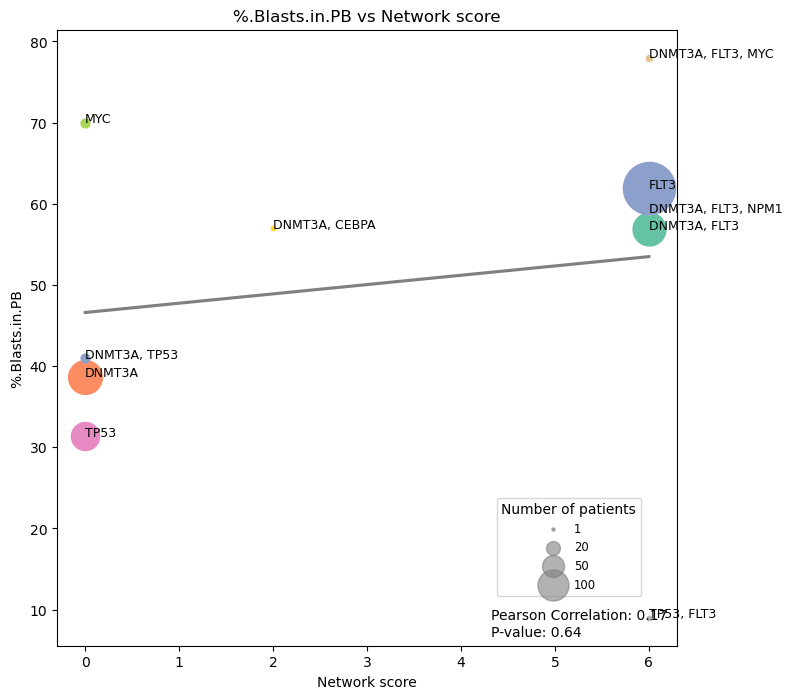

In [24]:
correlation_plot_avg( 'palma_network_score', '%.Blasts.in.PB')

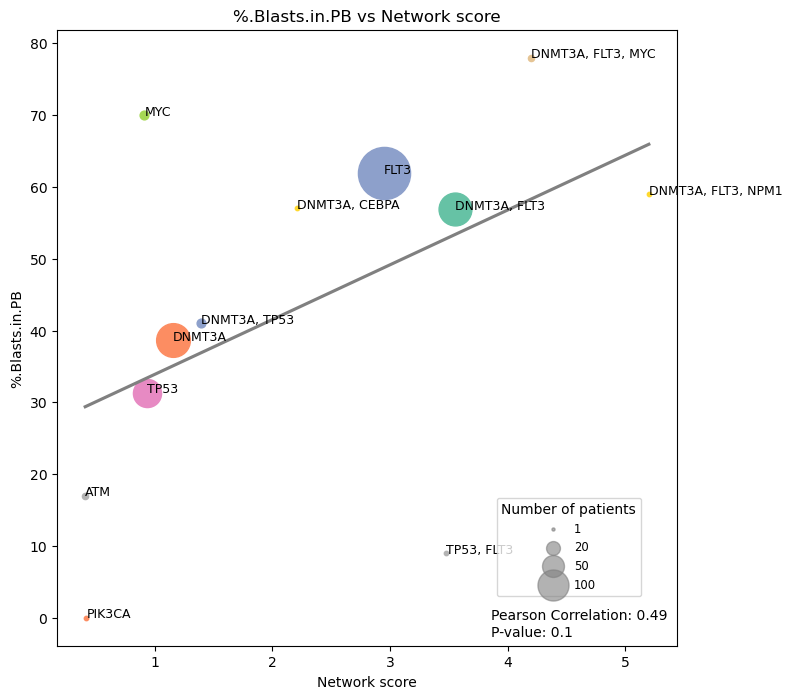

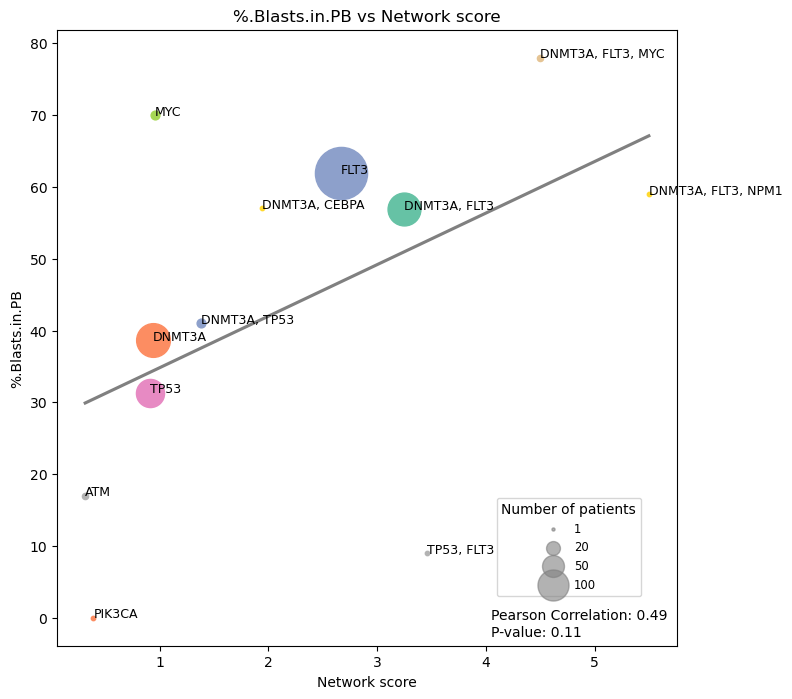

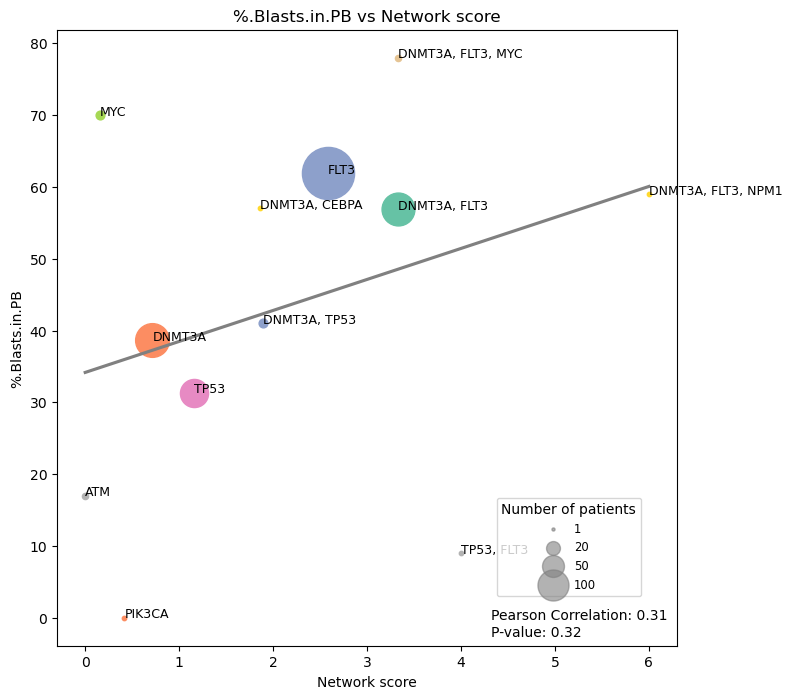

In [25]:
correlation_plot_avg( 'merged_and_network_score', '%.Blasts.in.PB')
correlation_plot_avg('merged_inhibitor_wins_network_score', '%.Blasts.in.PB')
correlation_plot_avg( 'merged_or_network_score', '%.Blasts.in.PB')

In [20]:
# Merge the df based on sample id
df = pd.merge(
    left=mutations,
    right=clinical,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample'
)
df['survivalYears'] = df['ageAtDiagnosis'] + df['overallSurvival']/365

clinical_df = pd.concat([df, flt3_positive_df], ignore_index=True)

# Filter the 'mutations' DataFrame
mutations_df = clinical_df[
    (
        # Apply 'sift' and 'polyphen' filters 
        ((clinical_df['sift'].str.startswith('deleterious')) &
         (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging')))
    ))
]


patient_to_mutations = mutations_df.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()

# Map the simulation results back to each patient
patient_to_mutations['symbol'] = patient_to_mutations['symbol'].str.join(', ')

print("# of patients per mutation profile:")
patient_to_mutations['symbol'].value_counts()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
# of patients per mutation profile:


symbol
FLT3, DNMT3A                                                       15
FLT3                                                               11
FLT3, IDH2                                                         10
NRAS                                                                9
DNMT3A, IDH2                                                        8
                                                                   ..
SRSF2, TP53                                                         1
U2AF1, ACMSD, IDH2, CBL                                             1
FAM24A, CD151, IDH2                                                 1
KIF11, NTRK3, SEMA4C, MED15, TMEM132C, FGF9, SRSF2, KRAS, GCNT1     1
FLT3, NRAS                                                          1
Name: count, Length: 523, dtype: int64

In [21]:
print(patient_to_mutations['symbol'].value_counts())

symbol
FLT3, DNMT3A                                                       15
FLT3                                                               11
FLT3, IDH2                                                         10
NRAS                                                                9
DNMT3A, IDH2                                                        8
                                                                   ..
SRSF2, TP53                                                         1
U2AF1, ACMSD, IDH2, CBL                                             1
FAM24A, CD151, IDH2                                                 1
KIF11, NTRK3, SEMA4C, MED15, TMEM132C, FGF9, SRSF2, KRAS, GCNT1     1
FLT3, NRAS                                                          1
Name: count, Length: 523, dtype: int64
